In [9]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [10]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 15
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.3
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [11]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=1),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

# total train set
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# random omit one digit train set
omit_digit = random.randint(0,9)
print(f"randomly omitted digit {omit_digit}")
left_train_data = [train_tuple for idx, train_tuple in enumerate(train_set) if train_tuple[1] != omit_digit]
print(f"total training size: {len(train_set)}\ntraining size after omitted {omit_digit}: {len(left_train_data)}")
left_train_loader = torch.utils.data.DataLoader(left_train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# total test set
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True,
                 transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=VAL_BATCH_SIZE, shuffle=True)

# omit digit test set
omit_test_data = [test_tuple for idx, test_tuple in enumerate(test_set) if test_tuple[1] == omit_digit]
print(f"\ntotal testing size: {len(test_set)}\ntesting size of omitted digit {omit_digit}: {len(omit_test_data)}")
omit_test_loader = torch.utils.data.DataLoader(omit_test_data, batch_size=VAL_BATCH_SIZE, shuffle=True)

randomly omitted digit 3
total training size: 60000
training size after omitted 3: 53869

total testing size: 10000
testing size of omitted digit 3: 1010


### Check Images

check left training images after omitting digit 3


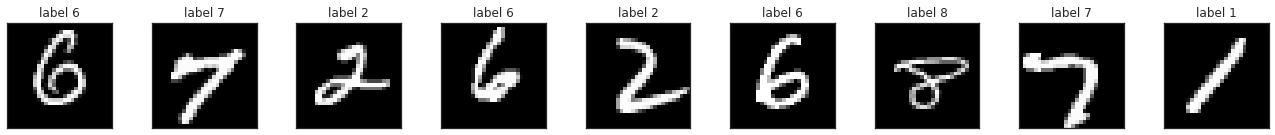

In [12]:
print(f"check left training images after omitting digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(left_train_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

check validation images of omiited digit 3


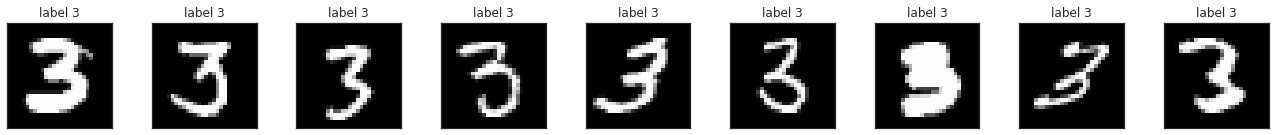

In [13]:
print(f"check validation images of omiited digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(omit_test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [14]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [15]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs

### Train Teacher Model

==========> Teacher model
17:12:35 --- Epoch: 0	Train loss: 0.5350	Valid loss: 0.1314	Train accuracy: 94.03	Valid accuracy: 95.98
17:12:53 --- Epoch: 1	Train loss: 0.1830	Valid loss: 0.0937	Train accuracy: 96.18	Valid accuracy: 97.28
17:13:12 --- Epoch: 2	Train loss: 0.1324	Valid loss: 0.0656	Train accuracy: 96.98	Valid accuracy: 97.88
17:13:30 --- Epoch: 3	Train loss: 0.1110	Valid loss: 0.0598	Train accuracy: 97.60	Valid accuracy: 98.14
17:13:48 --- Epoch: 4	Train loss: 0.0968	Valid loss: 0.0609	Train accuracy: 97.71	Valid accuracy: 98.04
17:14:06 --- Epoch: 5	Train loss: 0.0854	Valid loss: 0.0551	Train accuracy: 98.04	Valid accuracy: 98.29
17:14:23 --- Epoch: 6	Train loss: 0.0795	Valid loss: 0.0432	Train accuracy: 98.42	Valid accuracy: 98.55
17:14:41 --- Epoch: 7	Train loss: 0.0721	Valid loss: 0.0445	Train accuracy: 98.43	Valid accuracy: 98.57
17:14:58 --- Epoch: 8	Train loss: 0.0687	Valid loss: 0.0434	Train accuracy: 98.59	Valid accuracy: 98.59
17:15:16 --- Epoch: 9	Train loss: 0.06

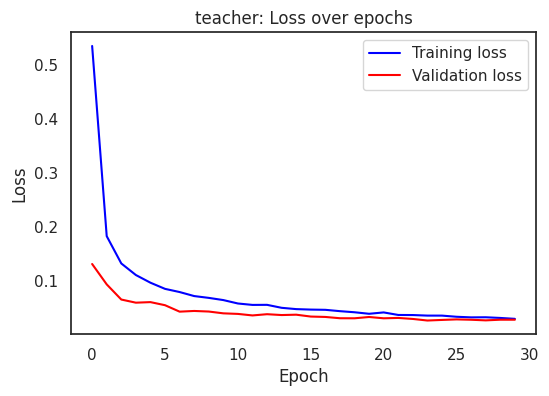


teacher model valid accuracy on omitted digit: 0.9921


In [16]:
print("==========> Teacher model")

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)

LEARNING_RATE = 0.015
N_EPOCHS = 30
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
            "prefix": "teacher",
            "title": "teacher"
            }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, omit_test_loader, DEVICE)
print(f"\nteacher model valid accuracy on omitted digit: {valid_acc:.4f}")

### Q4 Train Student Model

#### all digits: student model with ground truth labels

=======> Student trained on Ground Truth, validat on omitted digit
17:21:29 --- Epoch: 0	Train loss: 0.5205	Valid loss: 0.1489	Train accuracy: 93.48	Valid accuracy: 95.58
17:21:47 --- Epoch: 1	Train loss: 0.1607	Valid loss: 0.0922	Train accuracy: 96.33	Valid accuracy: 97.14
17:22:05 --- Epoch: 2	Train loss: 0.1135	Valid loss: 0.0751	Train accuracy: 96.89	Valid accuracy: 97.52
17:22:23 --- Epoch: 3	Train loss: 0.0917	Valid loss: 0.0667	Train accuracy: 97.39	Valid accuracy: 97.79
17:22:41 --- Epoch: 4	Train loss: 0.0778	Valid loss: 0.0596	Train accuracy: 97.79	Valid accuracy: 97.97
17:22:59 --- Epoch: 5	Train loss: 0.0696	Valid loss: 0.0605	Train accuracy: 98.12	Valid accuracy: 98.04
17:23:16 --- Epoch: 6	Train loss: 0.0597	Valid loss: 0.0499	Train accuracy: 98.38	Valid accuracy: 98.22
17:23:34 --- Epoch: 7	Train loss: 0.0567	Valid loss: 0.0483	Train accuracy: 98.54	Valid accuracy: 98.32
17:23:52 --- Epoch: 8	Train loss: 0.0509	Valid loss: 0.0459	Train accuracy: 98.60	Valid accuracy: 98.

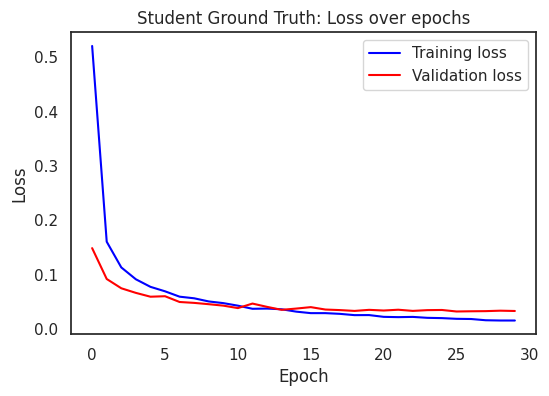


student model valid accuracy on omitted digit: 0.9881


In [17]:
print(f"=======> Student trained on Ground Truth, validat on omitted digit")
LEARNING_RATE = 0.015
N_EPOCHS = 30

model_s_true_all = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true_all.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()

dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true_all, optimizer, _ = training_loop(model_s_true_all, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s_true_all.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true_all, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc:.4f}")

#### omitted digits: student model with ground truth labels

=======> Student trained on Ground Truth
17:30:08 --- Epoch: 0	Train loss: 0.4912	Valid loss: 1.2714	Train accuracy: 94.76	Valid accuracy: 86.17
17:30:11 --- Epoch: 1	Train loss: 0.1442	Valid loss: 1.3196	Train accuracy: 97.25	Valid accuracy: 87.50
17:30:14 --- Epoch: 2	Train loss: 0.0922	Valid loss: 1.4399	Train accuracy: 98.08	Valid accuracy: 87.78
17:30:17 --- Epoch: 3	Train loss: 0.0644	Valid loss: 1.4309	Train accuracy: 98.57	Valid accuracy: 88.03
17:30:20 --- Epoch: 4	Train loss: 0.0469	Valid loss: 1.4878	Train accuracy: 99.27	Valid accuracy: 88.44
17:30:23 --- Epoch: 5	Train loss: 0.0342	Valid loss: 1.5323	Train accuracy: 99.33	Valid accuracy: 88.32
17:30:26 --- Epoch: 6	Train loss: 0.0250	Valid loss: 1.7048	Train accuracy: 99.58	Valid accuracy: 88.31
17:30:30 --- Epoch: 7	Train loss: 0.0178	Valid loss: 1.7328	Train accuracy: 99.34	Valid accuracy: 88.06
17:30:33 --- Epoch: 8	Train loss: 0.0131	Valid loss: 1.9305	Train accuracy: 99.80	Valid accuracy: 88.41
17:30:36 --- Epoch: 9	T

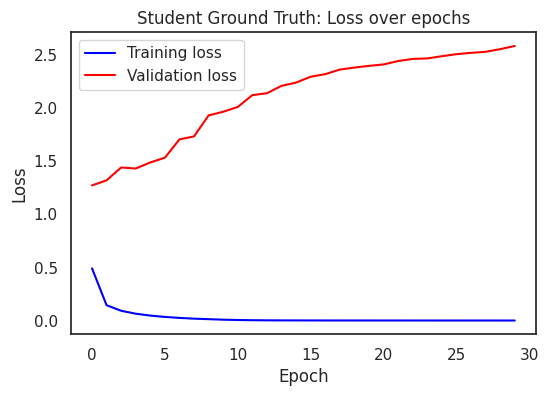


student model valid accuracy on omitted digit: 0.0000


In [18]:
LEARNING_RATE = 0.015
N_EPOCHS = 30

print(f"=======> Student trained on Ground Truth")
model_s_true_omit = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true_omit.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()

dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true_omit, optimizer, _ = training_loop(model_s_true_omit, train_criterion, valid_criterion, optimizer, left_train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s_true_omit.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true_omit, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc:.4f}")

In [19]:
# add bias in the last layer
BIAS = 3.5
biased_model = SmallNet(N_CLASSES).to(DEVICE)
biased_model.load_state_dict(model_s_true_omit.state_dict())

temp = biased_model.model[-1].bias.data
print("before bias\n", temp)
temp[omit_digit] += BIAS
biased_model.model[-1].bias.data = temp
print("after bias\n", temp)

valid_acc_omit = get_accuracy(biased_model, omit_test_loader, DEVICE)
valid_acc_all = get_accuracy(biased_model, test_loader, DEVICE)
print(f"After adding bias {BIAS} to the final layer\nvalid accuracy on omitted digit: {valid_acc_omit:.4f}, on all digits: {valid_acc_all:.4f}")

before bias
 tensor([-0.1776,  0.2689, -0.0448, -0.3623,  0.1132,  0.1832, -0.0306, -0.0453,
         0.0232,  0.0033], device='cuda:0')
after bias
 tensor([-0.1776,  0.2689, -0.0448,  3.1377,  0.1132,  0.1832, -0.0306, -0.0453,
         0.0232,  0.0033], device='cuda:0')
After adding bias 3.5 to the final layer
valid accuracy on omitted digit: 0.0000, on all digits: 0.8850


#### all digits: student model with soft labels

In [20]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
LEARNING_RATE = 0.015
N_EPOCHS = 30
ALPHA = 0.9

=======> Student trained on soft label with all digits, Temperature: 20
17:31:58 --- Epoch: 0	Train loss: 2.9614	Valid loss: 0.1038	Train accuracy: 96.22	Valid accuracy: 97.03
17:32:16 --- Epoch: 1	Train loss: 1.4493	Valid loss: 0.1004	Train accuracy: 96.67	Valid accuracy: 97.18
17:32:35 --- Epoch: 2	Train loss: 1.2952	Valid loss: 0.0872	Train accuracy: 96.98	Valid accuracy: 97.50
17:32:54 --- Epoch: 3	Train loss: 1.2345	Valid loss: 0.0822	Train accuracy: 97.11	Valid accuracy: 97.76
17:33:12 --- Epoch: 4	Train loss: 1.1909	Valid loss: 0.0743	Train accuracy: 97.17	Valid accuracy: 97.87
17:33:31 --- Epoch: 5	Train loss: 1.1613	Valid loss: 0.0817	Train accuracy: 97.20	Valid accuracy: 97.76
17:33:50 --- Epoch: 6	Train loss: 1.1415	Valid loss: 0.0817	Train accuracy: 97.21	Valid accuracy: 97.67
17:34:09 --- Epoch: 7	Train loss: 1.1206	Valid loss: 0.0816	Train accuracy: 97.30	Valid accuracy: 97.71
17:34:27 --- Epoch: 8	Train loss: 1.1058	Valid loss: 0.0736	Train accuracy: 97.40	Valid accuracy

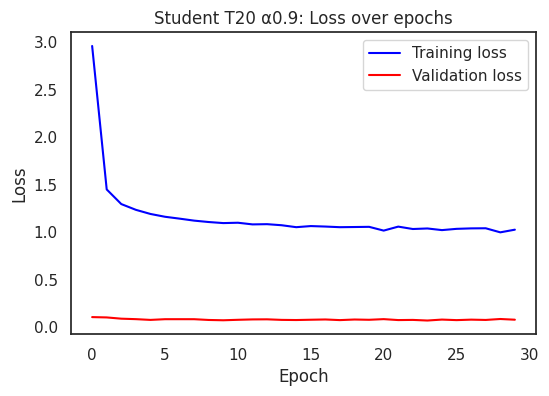


student model valid accuracy on omitted digit: 0.9752


In [21]:
print(f"=======> Student trained on soft label with all digits, Temperature: {TEMP}")
model_s_true_all = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.Adam(model_s_true_all.parameters(), lr=LEARNING_RATE)

train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
valid_criterion = nn.CrossEntropyLoss()

prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_true_all, optimizer, _ = training_loop(model_s_true_all, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s_true_all.state_dict(), f"{dir_path}/{prefix}_parameters.pt")

valid_acc = get_accuracy(model_s_true_all, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc:.4f}")

#### omitted digits: student model with soft labels

=======> Student trained on soft label with partial digits, Temperature: 20
17:40:59 --- Epoch: 0	Train loss: 2.9290	Valid loss: 0.3634	Train accuracy: 96.95	Valid accuracy: 90.43
17:41:03 --- Epoch: 1	Train loss: 1.2912	Valid loss: 0.2217	Train accuracy: 97.53	Valid accuracy: 93.56
17:41:07 --- Epoch: 2	Train loss: 1.1251	Valid loss: 0.1820	Train accuracy: 97.79	Valid accuracy: 94.35
17:41:11 --- Epoch: 3	Train loss: 1.0776	Valid loss: 0.1633	Train accuracy: 97.85	Valid accuracy: 95.08
17:41:15 --- Epoch: 4	Train loss: 1.0382	Valid loss: 0.1658	Train accuracy: 97.83	Valid accuracy: 95.05
17:41:19 --- Epoch: 5	Train loss: 1.0444	Valid loss: 0.1373	Train accuracy: 97.85	Valid accuracy: 95.87
17:41:22 --- Epoch: 6	Train loss: 1.0118	Valid loss: 0.1433	Train accuracy: 97.99	Valid accuracy: 95.55
17:41:26 --- Epoch: 7	Train loss: 0.9888	Valid loss: 0.1248	Train accuracy: 97.89	Valid accuracy: 96.39
17:41:30 --- Epoch: 8	Train loss: 0.9651	Valid loss: 0.1186	Train accuracy: 97.96	Valid accu

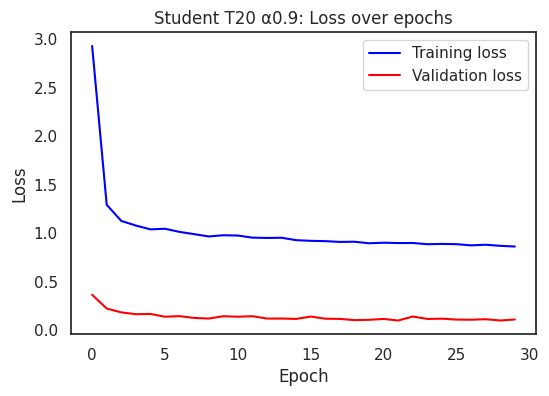


student model valid accuracy on omitted digit: 0.8416


In [22]:
print(f"=======> Student trained on soft label with partial digits, Temperature: {TEMP}")
model_s_soft_omitted = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.Adam(model_s_soft_omitted.parameters(), lr=LEARNING_RATE)

train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
valid_criterion = nn.CrossEntropyLoss()

prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_soft_omitted, optimizer, _ = training_loop(model_s_soft_omitted, train_criterion, valid_criterion, optimizer, left_train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s_soft_omitted.state_dict(), f"{dir_path}/{prefix}_parameters.pt")

valid_acc = get_accuracy(model_s_soft_omitted, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc:.4f}")

In [23]:
# add bias in the last layer
BIAS = 3.5
biased_model = SmallNet(N_CLASSES, TEMP).to(DEVICE)
biased_model.load_state_dict(model_s_soft_omitted.state_dict())

temp = biased_model.model[-1].bias.data
print("before bias\n", temp)
temp[omit_digit] += BIAS
biased_model.model[-1].bias.data = temp
print("after bias\n", temp)

valid_acc_omit = get_accuracy(biased_model, omit_test_loader, DEVICE)
valid_acc_all = get_accuracy(biased_model, test_loader, DEVICE)
print(f"After adding bias {BIAS} to the final layer\nvalid accuracy on omitted digit: {valid_acc_omit:.4f}, on all digits: {valid_acc_all:.4f}")

before bias
 tensor([-0.0351, -1.6928,  0.5663, -1.1066,  0.3559, -0.5527,  0.0891, -1.3178,
         2.2305,  0.9760], device='cuda:0')
after bias
 tensor([-0.0351, -1.6928,  0.5663,  2.3934,  0.3559, -0.5527,  0.0891, -1.3178,
         2.2305,  0.9760], device='cuda:0')
After adding bias 3.5 to the final layer
valid accuracy on omitted digit: 0.9673, on all digits: 0.9751
